In [3]:
from functions_ngates_v2 import calc_variance_pure, calc_variance_ng_cnot_batched
import torch as th
import numpy as np
import matplotlib.pyplot as plt
import cProfile
from tqdm.notebook import tqdm

In [4]:
N = 6
layers1 = np.arange(2, 15, 2)

In [ ]:
result1 = [calc_variance_pure(N, l, device='cpu', n_sim=5000) for l in tqdm(layers1)]

  0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
result2 = [calc_variance_ng_cnot_batched(N, l, device='cuda', n_sim=2000, n_sim_noise=750) for l in tqdm(layers1)]

  0%|          | 0/7 [00:00<?, ?it/s]

In [7]:
th.save(result2, 'result2_6q_cnot.pt')

In [8]:
result1 =th.load('result1_6q_cnot.pt')
result2 =th.load('result2_6q_cnot.pt')

In [9]:
var1 = []
var2 = []
var0 = []

for l in range(len(layers1)):
    var1.append(th.std(result1[l]))
    var2.append(th.std(th.mean(result2[l], dim=1)).cpu())
    var0.append(th.std(result2[l][:,0]).cpu())

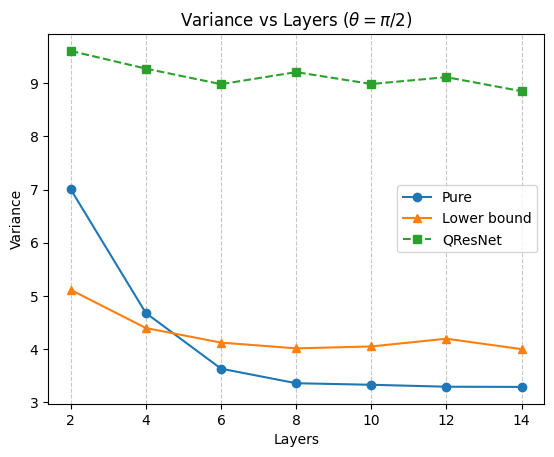

In [10]:
plt.plot(layers1, var1, marker='o', label='Pure')
plt.plot(layers1, var2, marker='^', label='Lower bound')
plt.plot(layers1, var0, marker='s', label='QResNet', linestyle='--')
plt.xlabel('Layers')
plt.grid(axis='x', which='both', linestyle='--', alpha=0.7)
plt.xticks(layers1)
plt.ylabel('Variance')
plt.title(r'Variance vs Layers ($\theta=\pi/2$)')
plt.legend()
plt.show()